In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import rasterio
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from osdatahub import NGD
from osdatahub import Extent
from dotenv import load_dotenv


### Create Urban Mask

In [3]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub
load_dotenv()
key_os = os.environ['KEY']

In [4]:
ngd_collections = NGD.get_collections()
for collection in ngd_collections['collections']:
    print(f' - {collection["title"]} ({collection["id"]})')

 - Building v1 (bld-fts-building-1)
 - Building Line v1 (bld-fts-buildingline-1)
 - Building Part v1 (bld-fts-buildingpart-1)
 - Named Area v1 (gnm-fts-namedarea-1)
 - Named Point v1 (gnm-fts-namedpoint-1)
 - Land v1 (lnd-fts-land-1)
 - Landform v1 (lnd-fts-landform-1)
 - Landform Line v1 (lnd-fts-landformline-1)
 - Landform Point v1 (lnd-fts-landformpoint-1)
 - Land Point v1 (lnd-fts-landpoint-1)
 - Site v1 (lus-fts-site-1)
 - Site Access Location v1 (lus-fts-siteaccesslocation-1)
 - Site Routing Point v1 (lus-fts-siteroutingpoint-1)
 - Compound Structure v1 (str-fts-compoundstructure-1)
 - Structure v1 (str-fts-structure-1)
 - Structure Line v1 (str-fts-structureline-1)
 - Structure Point v1 (str-fts-structurepoint-1)
 - Cartographic Rail Detail v1 (trn-fts-cartographicraildetail-1)
 - Rail v1 (trn-fts-rail-1)
 - Road Line v1 (trn-fts-roadline-1)
 - Road Track Or Path v1 (trn-fts-roadtrackorpath-1)
 - Connecting Link v1 (trn-ntwk-connectinglink-1)
 - Connecting Node v1 (trn-ntwk-conn

In [18]:
from mask_var import bb

# define layer for bbox extent & OS-API collection
lyr = rasterio.open("../content/tifs/189226695.27.tif")

# os collections for urban mask
collections = {'buildings' : 'bld-fts-buildingpart-1',
               'sites' : 'lus-fts-site-1', 
               'railways' : 'trn-fts-rail-1', 
               'land' : 'lnd-fts-land-1',
               'water' : 'wtr-fts-waterpoint-1'}

dict_os_layers = {}
gdf = gpd.GeoDataFrame()

# API variables
for key, value in collections.items():
    ngd = NGD(key_os, value)
    ngd_ = "ngd_" + key
    dict_os_layers[ngd_] = ngd.query(extent=bb(lyr), crs="EPSG:27700", max_results=1000000000)
    if dict_os_layers[ngd_]['numberReturned'] > 0:
        # add to dict
        dict_os_layers.update(dict_os_layers[ngd_])
        d =  gpd.GeoDataFrame.from_features((dict_os_layers[ngd_]), crs="EPSG:27700")
        gdf = gdf.append(d)
        print(ngd_ + " query contains the following number of features:" + str(dict_os_layers[ngd_]['numberReturned']))
    else:
        print(key + " query is empty!")

C:\Users\alexad\AppData\Local\Temp\ipykernel_7496\2586111840.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_buildings query contains the following number of features:2321


C:\Users\alexad\AppData\Local\Temp\ipykernel_7496\2586111840.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_sites query contains the following number of features:755
railways query is empty!


C:\Users\alexad\AppData\Local\Temp\ipykernel_7496\2586111840.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)
C:\Users\alexad\AppData\Local\Temp\ipykernel_7496\2586111840.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(d)


ngd_land query contains the following number of features:7572
ngd_water query contains the following number of features:34


In [19]:
from mask_var import urban_mask
mask = urban_mask(gdf)

(Text(0.5, 159.0, 'Eastings'), Text(265.21050721506003, 0.5, 'Northings'))

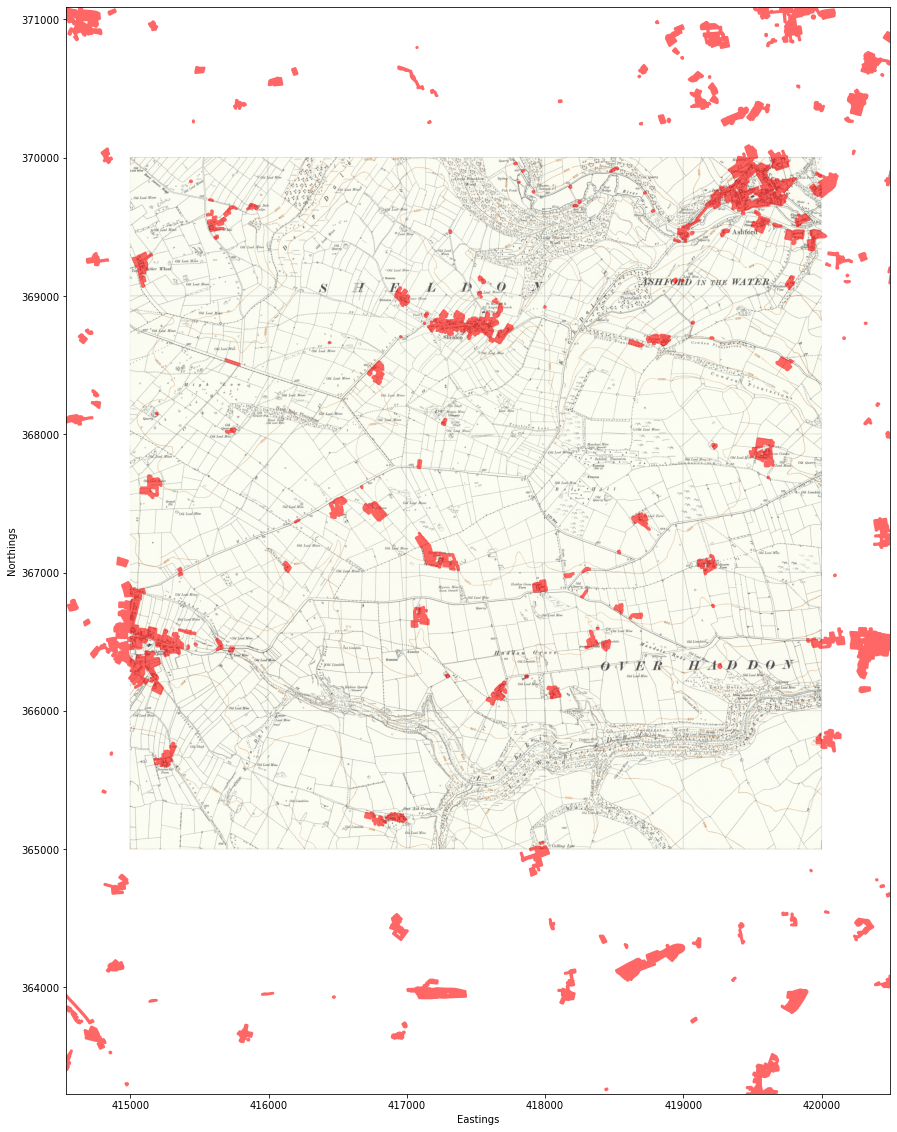

In [20]:
ax = mask.plot(color="red", alpha=0.6, figsize=(20, 20))
show(lyr, ax=ax, with_bounds=True)
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
#ax.set_xlim(417000, xmax=419000)
#ax.set_ylim(367000, ymax=369000)

### Create Text Mask
